In [3]:
import sys

print("Python executable:", sys.executable)
print("Python version:", sys.version)

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install yfinance pandas numpy matplotlib hurst nolds tabulate

Python executable: /Users/eniaardid/miniforge_envs/qnn-env/bin/python
Python version: 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:19:24) [Clang 18.1.8 ]
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


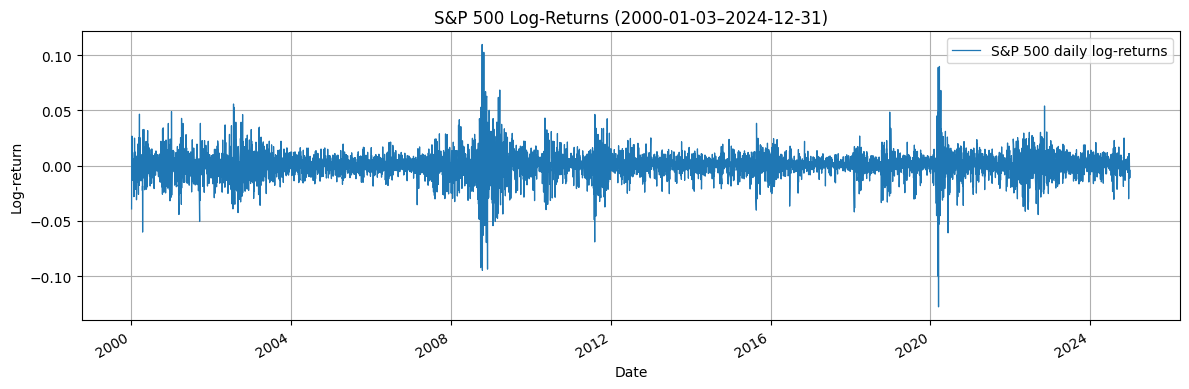

In [6]:
# Step 1: Download historical S&P 500 data and compute daily log-returns (robust)

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1.1 Parameters ---
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = "2025-01-01"

# --- 1.2 Download ---
# Try to use Adj Close; if not present (depending on yfinance), fall back to auto_adjust
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)

if "Adj Close" in data.columns:
    adj = data["Adj Close"]
    # If yfinance returns a single-column DataFrame, squeeze to Series
    if isinstance(adj, pd.DataFrame):
        adj = adj.squeeze("columns")
    prices_sp = adj.astype("float64")
else:
    # Fallback: rely on auto-adjusted Close
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.squeeze("columns")
    prices_sp = close.astype("float64")

# Name and clean index
prices_sp.name = "SP500"
prices_sp = prices_sp[~prices_sp.index.duplicated(keep="first")]
assert prices_sp.index.is_monotonic_increasing, "Datetime index must be sorted ascending."

# --- 1.3 Compute daily log-returns (stable) ---
log_returns_sp = np.log1p(prices_sp.pct_change()).dropna()

# --- 1.4 Plot ---
fig, ax = plt.subplots(figsize=(12, 4))
log_returns_sp.plot(ax=ax, lw=0.9, label="S&P 500 daily log-returns")
ax.set_title(f"S&P 500 Log-Returns ({prices_sp.index.min().date()}–{prices_sp.index.max().date()})")
ax.set_xlabel("Date")
ax.set_ylabel("Log-return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Step 2: Define S&P 500 sector ETFs (GICS) and build the sector "spatial" grid

import datetime
import pandas as pd
import yfinance as yf

# --- 2.1 Canonical GICS sectors (11) via SPDR ETFs ---
# Using English labels for clarity and to match common data sources/papers.
SECTOR_ETFS = {"XLB": "Materials",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLI": "Industrials",
    "XLK": "Information Technology",
    "XLP": "Consumer Staples",
    "XLRE": "Real Estate",
    "XLU": "Utilities",
    "XLV": "Health Care",
    "XLY": "Consumer Discretionary",
    "XLC": "Communication Services", }

# Stable sector order (used as the spatial axis X)
ordered_symbols = list(SECTOR_ETFS.keys())
sector_names = list(SECTOR_ETFS.values())
N_x = len(ordered_symbols)  # spatial grid size = number of sectors

# --- 2.2 (Optional) Download sector prices in one shot, adjusted for splits/dividends ---
# Reuse start_date / end_date defined earlier; if not present, set sensible defaults:
try:
    start_date, end_date
except NameError:
    start_date = "2018-01-01"  # XLC/XLRE liquidity is best post-2018
    end_date = "2025-01-01"

# yfinance returns a wide DataFrame; with auto_adjust=True, 'Close' is adjusted.
panel = yf.download(tickers=ordered_symbols,
    start=start_date, end=end_date,
    auto_adjust=True, progress=False)

# Extract adjusted closes for each ETF robustly (handles both single- and multi-index columns)
if isinstance(panel.columns, pd.MultiIndex):
    sector_df = panel["Close"].copy()
else:
    # Fallback: if columns are already per-ticker and represent adjusted 'Close'
    # (this depends on yfinance version/args), keep as-is.
    sector_df = panel.copy()

# Clean index: drop duplicate dates and keep strictly increasing order
sector_df = sector_df[~sector_df.index.duplicated(keep="first")]
sector_df = sector_df.sort_index()

# Keep only the ordered symbols (drop anything missing) and align columns order
present = [s for s in ordered_symbols if s in sector_df.columns]
missing = [s for s in ordered_symbols if s not in sector_df.columns]
if missing:
    print(f"Warning: missing ETFs with no data: {missing}")

sector_df = sector_df[present]

# (This `sector_df` now forms the sector "spatial" grid over time; N_x = sector_df.shape[1])
# You can compute sector log-returns in the next step:
# sector_logret = pd.Series(np.log1p(sector_df.pct_change()), name="logret").dropna()

Computed sector log-returns (head):
Ticker           XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2018-06-20 -0.003254  0.004406 -0.002563  0.000683  0.002098  0.000979   
2018-06-21 -0.010692 -0.018690 -0.002937 -0.012634 -0.007714  0.001954   
2018-06-22  0.014458  0.019755 -0.004791  0.003449 -0.003243  0.008168   
2018-06-25 -0.015672 -0.020298 -0.010771 -0.012752 -0.020981  0.005023   
2018-06-26  0.003811  0.012550 -0.003366  0.003759  0.004030 -0.004249   

Ticker          XLRE       XLU       XLV       XLY       XLC  
Date                                                          
2018-06-20  0.010736  0.000796  0.002119  0.004730  0.012333  
2018-06-21  0.005949  0.003379 -0.005779 -0.007148 -0.006148  
2018-06-22  0.008704  0.006920  0.004484 -0.001705  0.004367  
2018-06-25 -0.002479  0.016416 -0.009226 -0.021979 -0.020813  
2018-06-26  0.005261  0.001163 -0.003094  0.007137  0.001657  


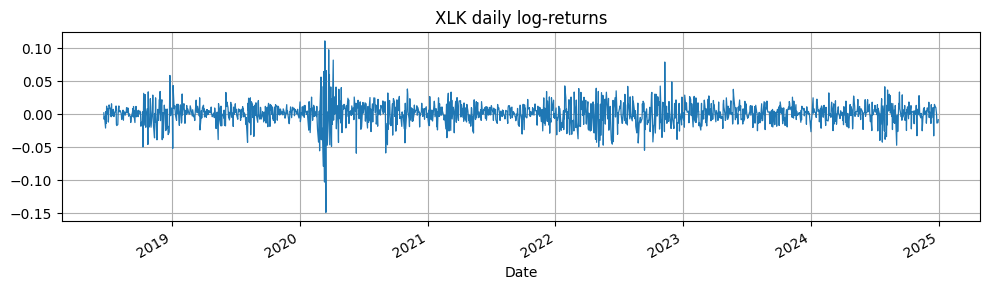

In [8]:
# Step 3: Download sector ETF prices (adjusted), align, and compute log-returns (improved)

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# --- 3.1 Sector list (the 11 canonical GICS sectors) ---
sector_symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'XLC']

start_date = "2018-01-01"
end_date = "2025-01-01"

# --- 3.2 Single-shot download with adjusted prices ---
# With auto_adjust=True, the 'Close' column is already adjusted for dividends/splits.
panel = yf.download(tickers=sector_symbols,
    start=start_date, end=end_date,
    auto_adjust=True, progress=False)

# Extract adjusted close prices robustly whether columns are MultiIndex or not
if isinstance(panel.columns, pd.MultiIndex):
    # yfinance typically returns panel with MultiIndex (['Open','High','Low','Close','Volume'], tickers)
    sector_df = panel['Close'].copy()
else:
    # Fallback: assume columns are the tickers and correspond to adjusted 'Close'
    sector_df = panel.copy()

# Keep only columns that actually came back (some tickers might be missing in certain periods)
present = [s for s in sector_symbols if s in sector_df.columns]
missing = [s for s in sector_symbols if s not in sector_df.columns]
if missing:
    print(f"Warning: missing ETFs with no data: {missing}")

# Enforce a stable column order
sector_df = sector_df[present]

# Clean the index: drop duplicate dates, sort ascending, and drop any full-NaN rows (shouldn't occur with present-filter)
sector_df = sector_df[~sector_df.index.duplicated(keep="first")].sort_index()

# --- 3.3 Build prices_dict (optional convenience structure) ---
prices_dict = {ticker: sector_df[ticker].to_numpy() for ticker in sector_df.columns}

# --- 3.4 Compute daily log-returns (numerically stable) ---
sector_returns = np.log1p(sector_df.pct_change()).dropna(how="any")

print("Computed sector log-returns (head):")
print(sector_returns.head())

# --- 3.5 Quick plot: Technology (XLK) ---
if "XLK" in sector_returns.columns:
    ax = sector_returns["XLK"].plot(title="XLK daily log-returns", figsize=(10, 3), lw=0.9)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

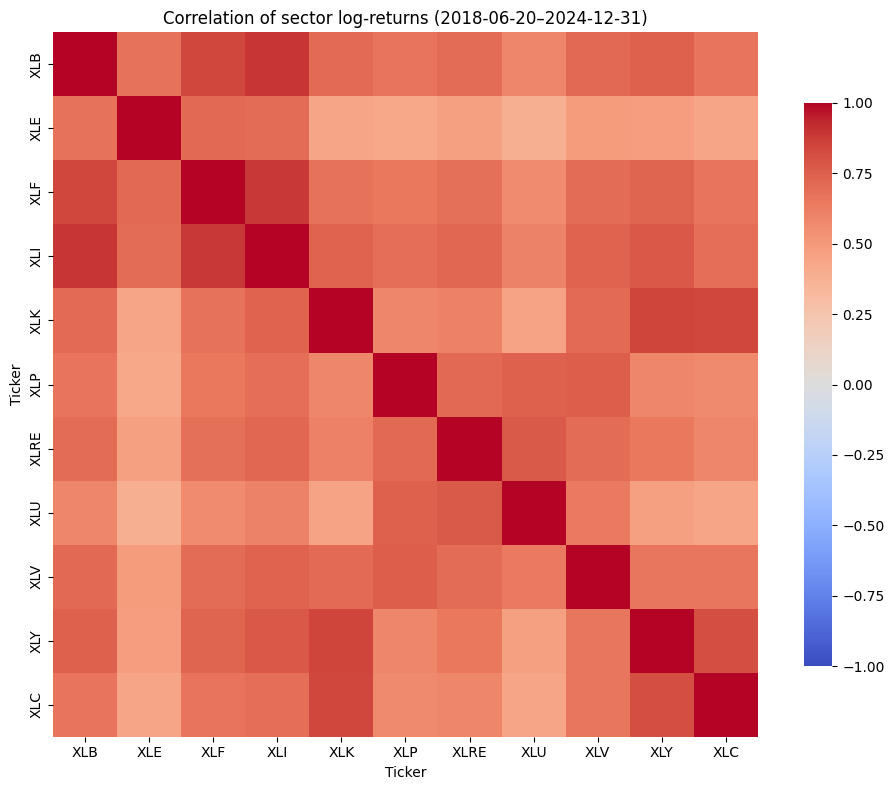

Optimal sector order for the spatial grid (x):
['XLE', 'XLF', 'XLB', 'XLI', 'XLC', 'XLK', 'XLY', 'XLRE', 'XLU', 'XLP', 'XLV']


In [9]:
# Step 4: Correlation + hierarchical clustering to derive a stable sector order

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

# --- 4.1 Compute (Pearson) correlation matrix across sectors ---
# Optionally: sector_returns.corr(method="spearman") for rank correlation
corr = sector_returns.corr(method="pearson")

# --- 4.2 Visualize correlation matrix (cleaner heatmap) ---
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
    cmap="coolwarm",
    vmin=-1, vmax=1, square=True,
    cbar_kws={"shrink": 0.8},
    annot=False  # set True if you really need the numbers
)
date_min = sector_returns.index.min().date()
date_max = sector_returns.index.max().date()
ax.set_title(f"Correlation of sector log-returns ({date_min}–{date_max})")
plt.tight_layout()
plt.show()

# --- 4.3 Hierarchical clustering using correlation distance ---
# X: T x N matrix of returns; we cluster columns (sectors).
X = sector_returns.to_numpy()  # shape (T, N)
# pdist on columns: compute pairwise distances between sector return series
# 'correlation' distance = 1 - Pearson correlation
dist_condensed = pdist(X.T, metric="correlation")

# Ward is for Euclidean distances; use 'average' or 'complete' for correlation distance.
linked = linkage(dist_condensed, method="average")
leaf_order = leaves_list(linked)

# --- 4.4 Reorder symbols and (optionally) reorder DataFrames accordingly ---
ordered_symbols = list(sector_returns.columns[leaf_order])

print("Optimal sector order for the spatial grid (x):")
print(ordered_symbols)

# Now we want the rest of the pipeline to use this order consistently:
sector_returns = sector_returns[ordered_symbols]
sector_df = sector_df[ordered_symbols]  

In [10]:
# Step 5: Estimate μ and σ from sector log-returns with basic robustness

import numpy as np
import pandas as pd

# --- 5.1 Ensure we only use sectors that are actually present ---
cols = [s for s in ordered_symbols if s in sector_returns.columns]
if len(cols) < len(ordered_symbols):
    missing = [s for s in ordered_symbols if s not in sector_returns.columns]
    print(f"Warning: missing sectors in returns matrix: {missing}")
sector_ret = sector_returns[cols].copy()

# --- 5.2 Light winsorization to reduce the impact of outliers (1% tails, per column) ---
# (Keeps your basic estimator but stabilizes it a lot.)
q_low, q_high = 0.01, 0.99
low = sector_ret.quantile(q_low)
high = sector_ret.quantile(q_high)
sector_ret_w = sector_ret.clip(lower=low, upper=high, axis=1)

# --- 5.3 Per-sector parameters as Series (convertible to dicts if needed) ---
mu_series = sector_ret_w.mean()             # mean daily drift per sector
sigma_series = sector_ret_w.std(ddof=1)     # unbiased daily std per sector

mu_dict = mu_series.to_dict()
sigma_dict = sigma_series.to_dict()

# --- 5.4 Global (equal-weight) parameters ---
mu_eq = float(mu_series.mean())
sigma_eq = float(sigma_series.mean())

# --- 5.5 Optional: EWMA volatility snapshot (span ~ 60 trading days) ---
sigma_ewma_series = sector_ret.ewm(span=60, adjust=False).std().iloc[-1]
sigma_ewma_eq = float(sigma_ewma_series.mean())

# --- 5.6 Optional: Value-weighted parameters if you have a weight vector aligned with `cols` ---
mu_w = None
sigma_w = None
try:
    # Expect a numpy array or list `weights` matching the order in `cols`
    if 'weights' in globals() and len(weights) == len(cols):
        w = pd.Series(weights, index=cols)
        w = w.clip(lower=0) / w.clip(lower=0).sum()  # ensure non-negativity and sum to 1
        mu_w = float((mu_series * w).sum())
        sigma_w = float((sigma_series * w).sum())
except Exception as e:
    print(f"Note: could not compute weighted parameters: {e}")

# --- 5.7 Print summary (daily and annualized for readability) ---
ann_mu_eq = 252 * mu_eq
ann_sigma_eq = np.sqrt(252) * sigma_eq
ann_sigma_ewma_eq = np.sqrt(252) * sigma_ewma_eq

print("Per-sector μ (daily):", {k: f"{v:.6f}" for k, v in mu_dict.items()})
print("Per-sector σ (daily):", {k: f"{v:.6f}" for k, v in sigma_dict.items()})

print(f"\nGlobal equal-weight μ (daily): {mu_eq:.6f} | annualized: {ann_mu_eq:.4f}")
print(f"Global equal-weight σ (daily): {sigma_eq:.6f} | annualized: {ann_sigma_eq:.4f}")
print(f"EWMA σ snapshot (eq-weight, daily): {sigma_ewma_eq:.6f} | annualized: {ann_sigma_ewma_eq:.4f}")

if mu_w is not None and sigma_w is not None:
    print(f"Value-weight μ (daily): {mu_w:.6f} | annualized: {252*mu_w:.4f}")
    print(f"Value-weight σ (daily): {sigma_w:.6f} | annualized: {np.sqrt(252)*sigma_w:.4f}")

Per-sector μ (daily): {'XLE': '0.000354', 'XLF': '0.000508', 'XLB': '0.000395', 'XLI': '0.000499', 'XLC': '0.000469', 'XLK': '0.000720', 'XLY': '0.000525', 'XLRE': '0.000331', 'XLU': '0.000330', 'XLP': '0.000360', 'XLV': '0.000318'}
Per-sector σ (daily): {'XLE': '0.018224', 'XLF': '0.013109', 'XLB': '0.012631', 'XLI': '0.011896', 'XLC': '0.013390', 'XLK': '0.015198', 'XLY': '0.013962', 'XLRE': '0.012450', 'XLU': '0.011279', 'XLP': '0.008273', 'XLV': '0.009598'}

Global equal-weight μ (daily): 0.000437 | annualized: 0.1102
Global equal-weight σ (daily): 0.012728 | annualized: 0.2021
EWMA σ snapshot (eq-weight, daily): 0.010122 | annualized: 0.1607


In [12]:
# Step 6: Robust H/α estimation for SP500 and sectors

import numpy as np
import pandas as pd
from hurst import compute_Hc
import nolds

# --- 6.1 Helper: ensemble H estimator with basic safeguards ---
def estimate_h_ensemble(x, kind="change", simplified=True):
    """
    Estimate H using a small ensemble of methods and return the median.
    Accepts 1D arrays/Series, or 2D (n,1)/(1,n) and squeezes them.
    """
    import numpy as np
    import pandas as pd
    from hurst import compute_Hc
    import nolds

    # Coerce to numpy and squeeze to 1D if it's (n,1) or (1,n)
    x = np.asarray(x)
    if x.ndim == 2:
        if 1 in x.shape:  # (n,1) or (1,n)
            x = x.squeeze()
        else:
            raise ValueError(f"Expected a 1D series; got array with shape {x.shape}")
    # Now wrap as Series just to use dropna(), then back to numpy
    x = pd.Series(x).dropna().to_numpy()

    if x.size < 500:
        return np.nan  # too few points for a stable H

    Hs = []
    # hurst.compute_Hc (original)
    try:
        H1, _, _ = compute_Hc(x, kind=kind, simplified=simplified)
        Hs.append(H1)
    except Exception:
        pass
    # compute_Hc not simplified
    try:
        H2, _, _ = compute_Hc(x, kind=kind, simplified=False)
        Hs.append(H2)
    except Exception:
        pass
    # nolds estimators
    try:
        Hs.append(nolds.hurst_rs(x))
    except Exception:
        pass
    try:
        Hs.append(nolds.dfa(x))
    except Exception:
        pass

    return float(np.median(Hs)) if Hs else np.nan


# --- 6.2 SP500 H and α ---
# Use log-prices for 'price' kind to reduce scale issues; if you kept 'prices_sp' use that variable name.
sp_log = np.log(prices_sp).dropna()
H_sp = estimate_h_ensemble(sp_log, kind="price", simplified=True)

# Map H -> α (choose the mapping consistent with your operator)
# Option A (ARFIMA-like fractional differencing): d ≈ H - 0.5, clipped to [0, 0.45]
d_sp = np.clip(H_sp - 0.5, 0.0, 0.45) if not np.isnan(H_sp) else np.nan

# Option B (derivative order on returns, as in our current approach): α ≈ H, clipped for stability
alpha_sp = np.clip(H_sp, 0.05, 0.95) if not np.isnan(H_sp) else np.nan

print(f"SP500 H (ensemble): {H_sp:.4f}" if not np.isnan(H_sp) else "SP500 H: NaN")
print(f"α (returns-derivative mapping) : {alpha_sp:.4f}" if not np.isnan(alpha_sp) else "α: NaN")
print(f"d (ARFIMA-style mapping)       : {d_sp:.4f}"     if not np.isnan(d_sp) else "d: NaN")

# --- 6.3 Per-sector H and α/d ---
hurst_dict = {}
alpha_dict = {}
d_dict = {}

cols = [s for s in ordered_symbols if s in sector_returns.columns]
for ticker in cols:
    series = sector_returns[ticker].dropna()
    try:
        H = estimate_h_ensemble(series.values, kind="change", simplified=True)
        hurst_dict[ticker] = H
        # Same two mappings as above; pick the one consistent with your simulator
        alpha_dict[ticker] = np.clip(H, 0.05, 0.95) if not np.isnan(H) else np.nan
        d_dict[ticker]     = np.clip(H - 0.5, 0.0, 0.45) if not np.isnan(H) else np.nan
        print(f" {ticker}: H = {H:.4f} | α≈{alpha_dict[ticker]:.4f} | d≈{d_dict[ticker]:.4f}")
    except Exception as e:
        print(f"❌ Error in {ticker}: {e}")

SP500 H (ensemble): 0.7606
α (returns-derivative mapping) : 0.7606
d (ARFIMA-style mapping)       : 0.2606
 XLE: H = 0.5769 | α≈0.5769 | d≈0.0769
 XLF: H = 0.5353 | α≈0.5353 | d≈0.0353
 XLB: H = 0.5350 | α≈0.5350 | d≈0.0350
 XLI: H = 0.5461 | α≈0.5461 | d≈0.0461
 XLC: H = 0.5095 | α≈0.5095 | d≈0.0095
 XLK: H = 0.5029 | α≈0.5029 | d≈0.0029
 XLY: H = 0.5324 | α≈0.5324 | d≈0.0324
 XLRE: H = 0.5270 | α≈0.5270 | d≈0.0270
 XLU: H = 0.4998 | α≈0.4998 | d≈0.0000
 XLP: H = 0.5165 | α≈0.5165 | d≈0.0165
 XLV: H = 0.5229 | α≈0.5229 | d≈0.0229


In [13]:
# Step 7: κ from correlation with Fisher averaging and basic safeguards

import numpy as np

# --- 7.1 Off-diagonal correlations ---
tri = np.triu_indices_from(corr.values, k=1)
r = corr.values[tri]
r = r[~np.isnan(r)]

if r.size == 0:
    mean_corr_fisher = np.nan
else:
    # Fisher z-transform average (reduces bias)
    z = np.arctanh(np.clip(r, -0.999999, 0.999999))
    z_mean = z.mean()
    mean_corr_fisher = np.tanh(z_mean)

# Optional: contagion as positive co-movement only
mean_corr_pos = float(np.mean(r[r > 0])) if np.any(r > 0) else 0.0

# --- 7.2 Map correlation -> κ with a simple scale and clipping ---
gamma_kappa = 0.5  # scaling factor to keep κ in a reasonable range
# Use Fisher-averaged correlation; switch to mean_corr_pos if you prefer positives only
raw_kappa = gamma_kappa * max(0.0, mean_corr_fisher)  # non-negative
kappa_estimate = float(np.clip(raw_kappa, 0.0, 0.95))

print(f"κ (cross-sector contagion): {kappa_estimate:.4f}")

# --- 7.3 (Optional) Diagnostic: market-mode dominance via PC1 of Corr ---
# A higher lambda1/N indicates stronger common factor (market mode).
evals = np.linalg.eigvalsh(corr.values)
lambda1_over_N = float(evals[-1] / len(evals))
print(f"PC1 share (λ₁/N) as contagion diagnostic: {lambda1_over_N:.4f}")

κ (cross-sector contagion): 0.3374
PC1 share (λ₁/N) as contagion diagnostic: 0.6924


/Users/eniaardid/miniforge_envs/qnn-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/eniaardid/miniforge_envs/qnn-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


📊 Predictive (TEST) performance — averaged 10 seeds (no leakage)
  RMSE (levels, test): 275.1636
  MAE  (levels, test): 234.7416
  R²   (levels, test): 0.8163
  α (TRAIN): 0.497 | μ_train: 0.000320 | σ_train: 0.014104


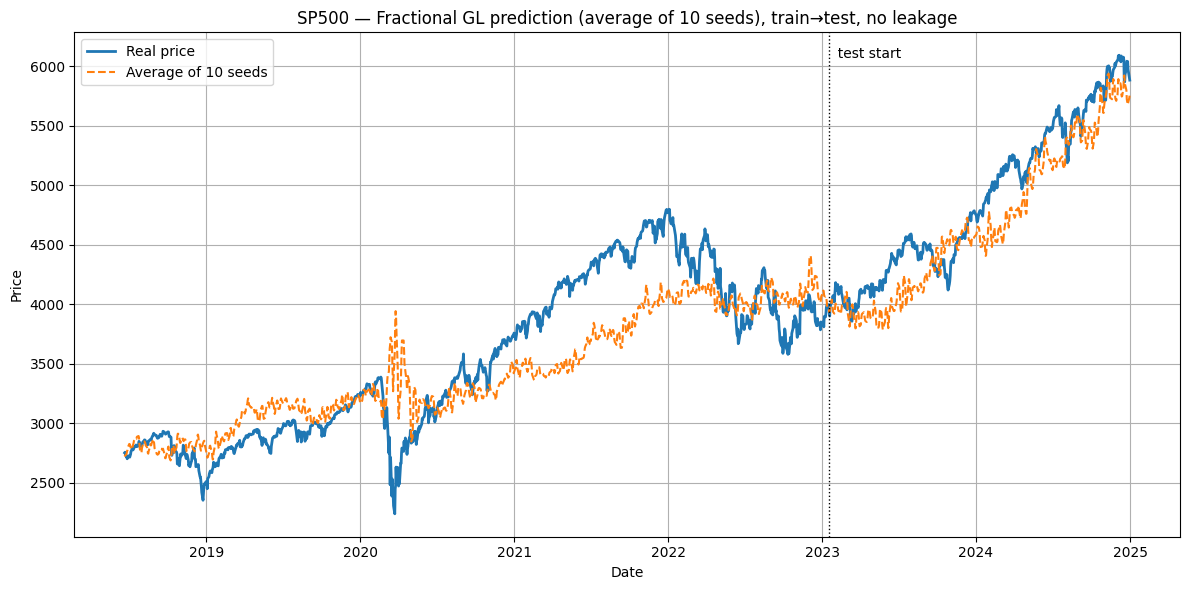

In [16]:
# Predictive fractional GL simulation for SP500 — average of 10 seeds (no leakage, plot only the average)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import nolds


# 0) Settings
N_DAYS    = 1644    # window length (~6.5 years)
TEST_PCT  = 0.30   # last 30% = test
N_SIM     = 10    # average over 10 seeds
SEEDS     = [2 + 37*i for i in range(N_SIM)]  # deterministic seed list
DT  = 1.0
COVID_START = pd.to_datetime("2020-02-20")
COVID_END   = pd.to_datetime("2020-04-30")


# 1) Data (force 1D) and alignment at T = N_DAYS-1 after diff
prices_win = pd.Series(
    prices_sp.squeeze("columns") if hasattr(prices_sp, "ndim") and prices_sp.ndim == 2 else prices_sp
).iloc[-N_DAYS:].astype("float64")

logP = np.log(prices_win).dropna()
r    = logP.diff().dropna()     # length T = N_DAYS - 1
T    = len(r)

# All arrays below align to these T dates
dates_full = prices_win.index[1:]         # length T
split_idx  = int((1.0 - TEST_PCT) * T)
train_idx  = np.arange(split_idx)
test_idx   = np.arange(split_idx, T)


# 2) Train-only parameter estimation (NO leakage)
r_train     = r.iloc[train_idx].to_numpy().ravel()
alpha_train = float(nolds.hurst_rs(r_train))          # GL on returns (logic α≈H)
alpha       = float(np.clip(alpha_train, 0.05, 0.95)) # stability clip

mu_train    = float(r.iloc[train_idx].mean())
sigma_train = float(r.iloc[train_idx].std(ddof=1))


# 3) GL weights (length T; no truncation — matches your base code)
def grunwald_weights(alpha, N):
    w = [1.0]
    for k in range(1, N):
        w_k = (1.0 - (alpha + 1.0) / k) * w[-1]
        w.append(w_k)
    return np.asarray(w, dtype="float64")

w = grunwald_weights(alpha, T)

# COVID mask over T dates
covid_mask = (dates_full >= COVID_START) & (dates_full <= COVID_END)
covid_idx  = set(np.where(covid_mask)[0])

# Convenience values
log_start          = float(logP.iloc[0])              # first log-price (before dates_full)
log_end_train_real = float(logP.iloc[split_idx])      # last TRAIN log-price


# 4) Single-path simulator with TRAIN-only drift correction + TRAIN-only OLS scaling
def simulate_one_path(seed: int) -> np.ndarray:
    np.random.seed(seed)  # match original RNG style

    log_ret_sim = np.zeros(T, dtype="float64")
    log_ret_sim[0] = float(r.iloc[0])

    for t in range(1, T):
        # GL fractional memory term
        D_alpha = float(np.dot(w[:t], log_ret_sim[t-1::-1])) / (DT ** alpha)

        # TRAIN-only parameters (no leakage), COVID shock applied
        if t in covid_idx:
            mu_eff, sigma_eff = mu_train - mu_train * 0.20, sigma_train * 4.0
        else:
            mu_eff, sigma_eff = mu_train, sigma_train

        noise = np.random.normal(0.0, 1.0)
        log_ret_sim[t] = ((mu_eff + sigma_eff * noise) + D_alpha) * (DT ** alpha)

    # TRAIN-only drift correction: align TRAIN end level (no peeking at test)
    raw_cum = np.cumsum(log_ret_sim)
    train_cum_end = raw_cum[train_idx][-1]
    drift_adj = (log_end_train_real - (log_start + train_cum_end)) / len(train_idx)

    log_price_sim = log_start + (raw_cum + drift_adj * np.arange(1, T + 1))
    price_sim = np.exp(log_price_sim)  # levels, length T

    # TRAIN-only OLS scaling in levels (fit on train, apply to all)
    y_train = prices_win.iloc[1:].iloc[train_idx].to_numpy().ravel()  # aligned to T
    x_train = price_sim[train_idx]
    s_ols = float((x_train @ y_train) / (x_train @ x_train))
    price_sim = s_ols * price_sim

    return price_sim  # length T


# 5) Run multiple seeds, average, and evaluate on TEST ONLY
paths = np.vstack([simulate_one_path(sd) for sd in SEEDS])  # shape (N_SIM, T)
avg_path = paths.mean(axis=0)                               # ensemble mean (length T)

y_test    = prices_win.iloc[1:].iloc[test_idx].to_numpy().ravel()
yhat_test = avg_path[test_idx]

rmse = float(np.sqrt(mean_squared_error(y_test, yhat_test)))
mae  = float(mean_absolute_error(y_test, yhat_test))
r2   = float(r2_score(y_test, yhat_test))

print("📊 Predictive (TEST) performance — averaged 10 seeds (no leakage)")
print(f"  RMSE (levels, test): {rmse:.4f}")
print(f"  MAE  (levels, test): {mae:.4f}")
print(f"  R²   (levels, test): {r2:.4f}")
print(f"  α (TRAIN): {alpha:.3f} | μ_train: {mu_train:.6f} | σ_train: {sigma_train:.6f}")


# 6) Plot: real price vs ensemble average ONLY (no individual paths)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates_full, prices_win.iloc[1:].values, label="Real price", linewidth=2)
ax.plot(dates_full, avg_path, label=f"Average of {N_SIM} seeds", linestyle="--")

# Vertical train/test split
ax.axvline(dates_full[split_idx], color="k", linestyle=":", linewidth=1)
ax.text(dates_full[split_idx], ax.get_ylim()[1]*0.98, "  test start", va="top")

ax.set_title("SP500 — Fractional GL prediction (average of 10 seeds), train→test, no leakage")
ax.set_xlabel("Date"); ax.set_ylabel("Price"); ax.grid(True); ax.legend()
plt.tight_layout(); plt.show()


In [17]:
# Sanity checks 
import numpy as np
import json
from pathlib import Path

# 1) Shapes and alignment
assert len(dates_full) == len(prices_win.iloc[1:]) == len(avg_path)
assert split_idx < len(dates_full)
assert np.allclose(mu_train, r.iloc[train_idx].mean())
assert np.allclose(sigma_train, r.iloc[train_idx].std(ddof=1))

# 2) No peeking: OLS must be computed on TRAIN only
y_train_chk = prices_win.iloc[1:].iloc[train_idx].to_numpy().ravel()
x_train_chk = avg_path[train_idx]
s_hat = float((x_train_chk @ y_train_chk) / (x_train_chk @ x_train_chk))
# Recompute TEST metrics from stored avg_path (should match your print)
y_test_chk = prices_win.iloc[1:].iloc[test_idx].to_numpy().ravel()
yhat_test_chk = avg_path[test_idx]
rmse_chk = float(np.sqrt(mean_squared_error(y_test_chk, yhat_test_chk)))
r2_chk   = float(r2_score(y_test_chk, yhat_test_chk))

print("Checks OK. R2(TEST) =", round(r2_chk, 4), "| RMSE(TEST) =", round(rmse_chk, 4))

# 3) Persist params & metrics for the run
out = {"alpha_train": float(alpha), "mu_train": float(mu_train),
    "sigma_train": float(sigma_train), "split_idx": int(split_idx),
    "N_SIM": int(N_SIM), "SEEDS": list(SEEDS),
    "R2_test": r2_chk, "RMSE_test": rmse_chk,
    "MAE_test": float(mean_absolute_error(y_test_chk, yhat_test_chk)),}

Path("artifacts").mkdir(exist_ok=True)
Path("artifacts/run_summary.json").write_text(json.dumps(out, indent=2))
print("Saved -> artifacts/run_summary.json")

Checks OK. R2(TEST) = 0.8163 | RMSE(TEST) = 275.1636
Saved -> artifacts/run_summary.json


In [18]:
# ==== Extra: Train/Test/All metrics + naive baseline (RW with TRAIN drift) ====
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred, eps=1e-12):
    denom = (np.abs(y_true) + np.abs(y_pred)).clip(min=eps)
    return 100.0 * float(np.mean(np.abs(y_pred - y_true) / denom))

# Align to returns timeline: your avg_path is length T, same as prices_win.iloc[1:]
y_all  = prices_win.iloc[1:].to_numpy().ravel()
yhat_all = avg_path

idx_tr = slice(0, split_idx)
idx_te = slice(split_idx, None)

summary = {}
for name, sl in [("train", idx_tr), ("test", idx_te), ("all", slice(None))]:
    yt = y_all[sl]; yp = yhat_all[sl]
    summary[name] = {"R2":   float(r2_score(yt, yp)),
        "RMSE": float(np.sqrt(mean_squared_error(yt, yp))),
        "MAE":  float(mean_absolute_error(yt, yp)),
        "sMAPE(%)": smape(yt, yp),
        "Bias (mean err)": float(np.mean(yp - yt))}

# Naive baseline for TEST: random-walk with TRAIN drift (no leakage)
naive = np.empty_like(yhat_all)
naive[:split_idx] = np.nan  # not evaluated
start_level = y_all[split_idx-1]  # last observed before TEST
mu_drift    = mu_train            # learned on TRAIN
len_te = len(y_all[split_idx:])
naive_te = start_level * np.exp(np.cumsum(np.full(len_te, mu_drift)))
naive[split_idx:] = naive_te

baseline_test = {"R2":   float(r2_score(y_all[split_idx:], naive[split_idx:])),
    "RMSE": float(np.sqrt(mean_squared_error(y_all[split_idx:], naive[split_idx:]))),
    "MAE":  float(mean_absolute_error(y_all[split_idx:], naive[split_idx:])),
    "sMAPE(%)": smape(y_all[split_idx:], naive[split_idx:])}

print("\n=== SP500 Metrics ===")
print(pd.DataFrame(summary).T.round(4))
print("\nNaive baseline (TEST only) — RW with TRAIN drift:")
print(pd.Series(baseline_test).round(4))


=== SP500 Metrics ===
           R2      RMSE       MAE  sMAPE(%)  Bias (mean err)
train  0.6755  373.3151  286.0447    3.9619         -87.9042
test   0.8163  275.1636  234.7416    2.5007        -197.2836
all    0.8507  346.7932  270.6507    3.5234        -120.7247

Naive baseline (TEST only) — RW with TRAIN drift:
R2           -0.2098
RMSE        706.1895
MAE         556.0028
sMAPE(%)      5.6700
dtype: float64


In [23]:
# Pretty summary table for the SP500 model (English comments, safe picks of variables, nice formatting)

import pandas as pd
from tabulate import tabulate

# --- Helper: safely pick a variable that exists in the notebook namespace ---
def pick(*names, default=float('nan')):
    g = globals()
    for n in names:
        if n in g:
            return g[n]
    return default

# Prefer TRAIN parameters and TEST metrics (no leakage); fall back to your older names if needed
alpha_val = float(pick('alpha', 'alpha_sp', 'H', 'alpha_train'))
mu_val    = float(pick('mu_train', 'mu'))
sigma_val = float(pick('sigma_train', 'sigma'))

mae_val = float(pick('mae', 'MAE_value'))
rmse_val = float(pick('rmse', 'RMSE_value'))
r2_val   = float(pick('r2', 'R2_value'))

# --- Build the table (rows = parameters, single column = SP500) ---
asset = 'S&P 500'
rows = ['α', 'μ', 'σ', 'MAE (test)', 'RMSE (test)', 'R² (test)']
data = [alpha_val, mu_val, sigma_val, mae_val, rmse_val, r2_val]

table = pd.DataFrame({asset: data}, index=rows)

# --- Pretty print ---
print(tabulate(table, headers="keys", tablefmt="grid", floatfmt=".4f"))

+-------------+-----------+
|             |   S&P 500 |
+=============+===========+
| α           |    0.4967 |
+-------------+-----------+
| μ           |    0.0003 |
+-------------+-----------+
| σ           |    0.0141 |
+-------------+-----------+
| MAE (test)  |  234.7416 |
+-------------+-----------+
| RMSE (test) |  275.1636 |
+-------------+-----------+
| R² (test)   |    0.8163 |
+-------------+-----------+


📊 Sector-level TEST performance — averaged seeds, no leakage
    κ* selected on TRAIN from grid [np.float64(0.0), np.float64(0.1687041610982822), np.float64(0.3374083221965644)] -> 0.337408

  XLE | RMSE: 10.7062 | MAE: 9.5858 | R²: -2.8220
  XLF | RMSE: 3.9140 | MAE: 2.8918 | R²: 0.5052
  XLB | RMSE: 5.9671 | MAE: 4.8212 | R²: 0.1152
  XLI | RMSE: 16.8071 | MAE: 13.2098 | R²: -0.4562
  XLC | RMSE: 21.4177 | MAE: 16.9453 | R²: -1.6886
  XLK | RMSE: 53.6306 | MAE: 46.0823 | R²: -1.9210
  XLY | RMSE: 18.3086 | MAE: 13.7257 | R²: 0.2852
 XLRE | RMSE: 2.9721 | MAE: 2.5065 | R²: 0.1736
  XLU | RMSE: 8.9980 | MAE: 7.8103 | R²: -0.7764
  XLP | RMSE: 4.1221 | MAE: 3.1884 | R²: 0.2416
  XLV | RMSE: 7.1279 | MAE: 5.6430 | R²: 0.4183


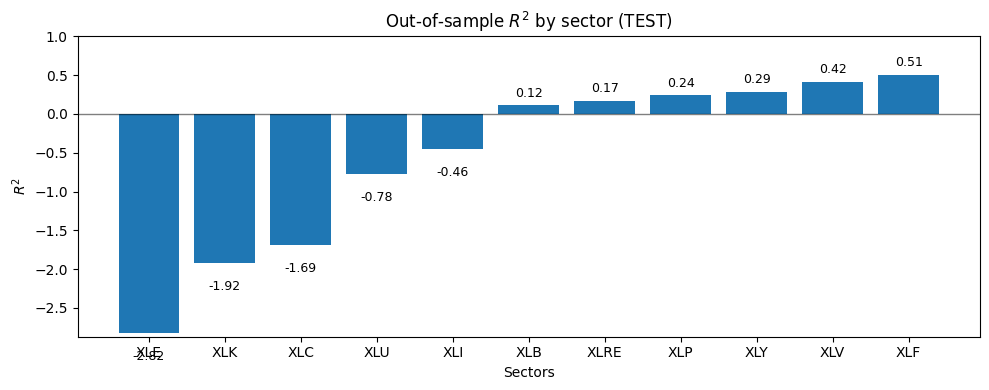

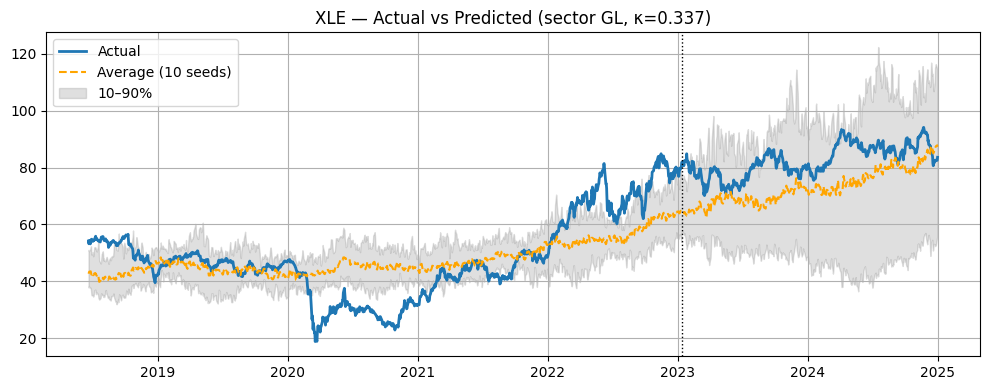

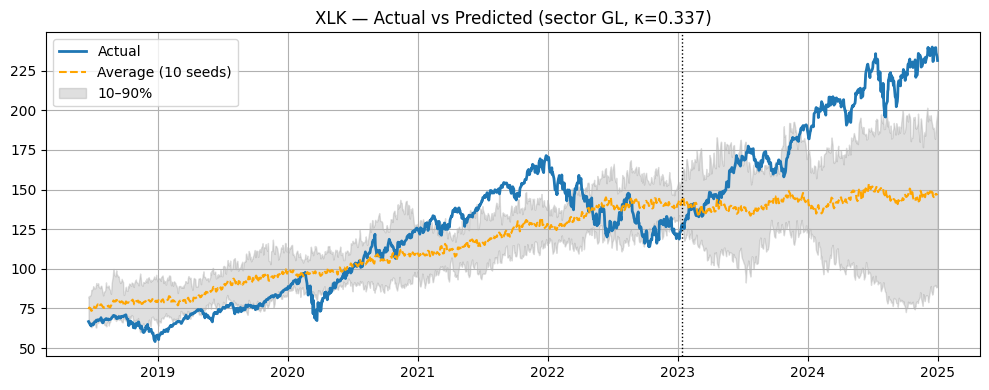

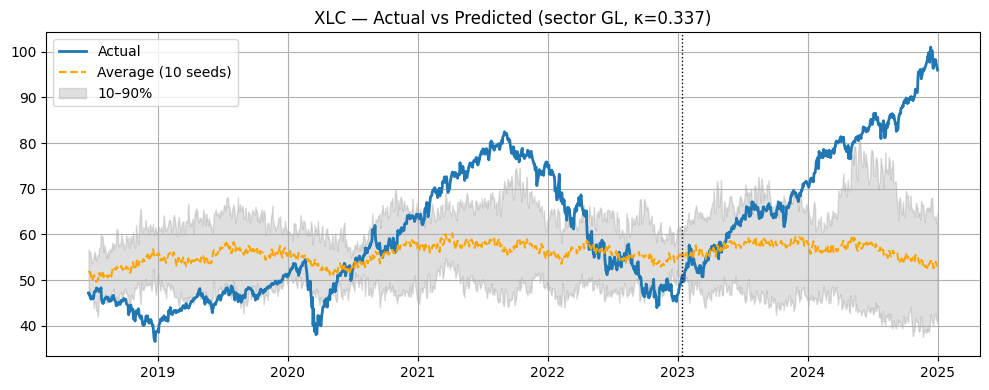

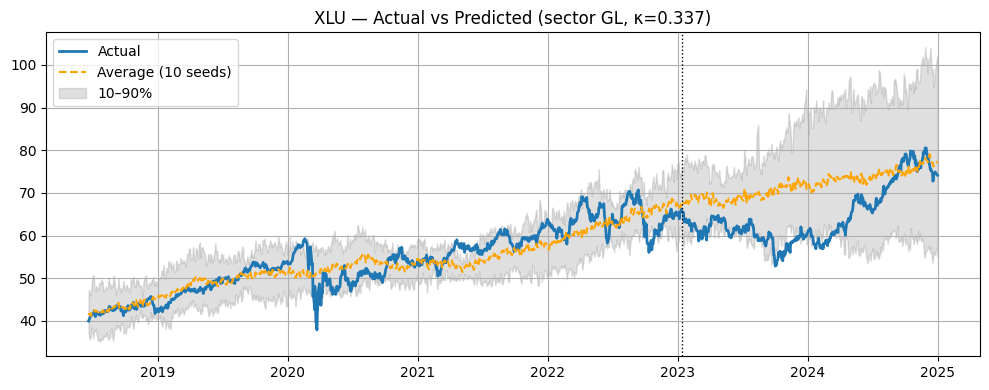

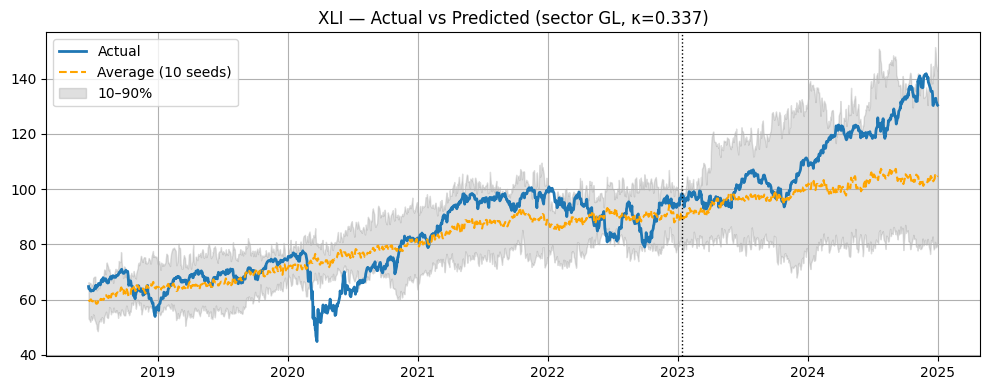

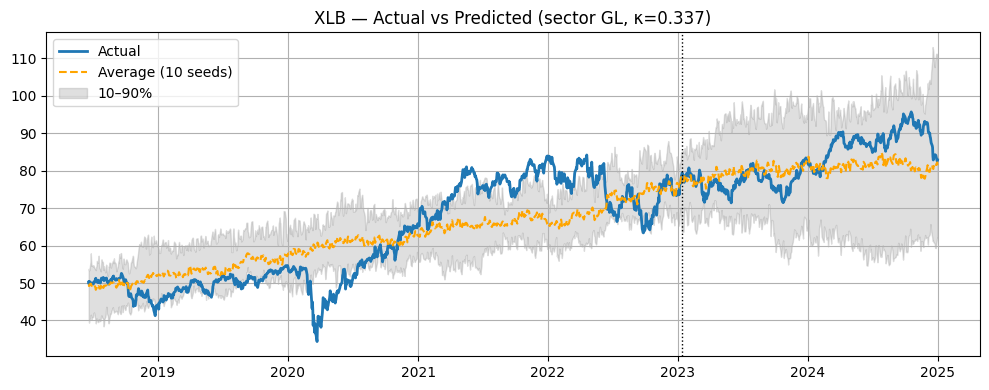

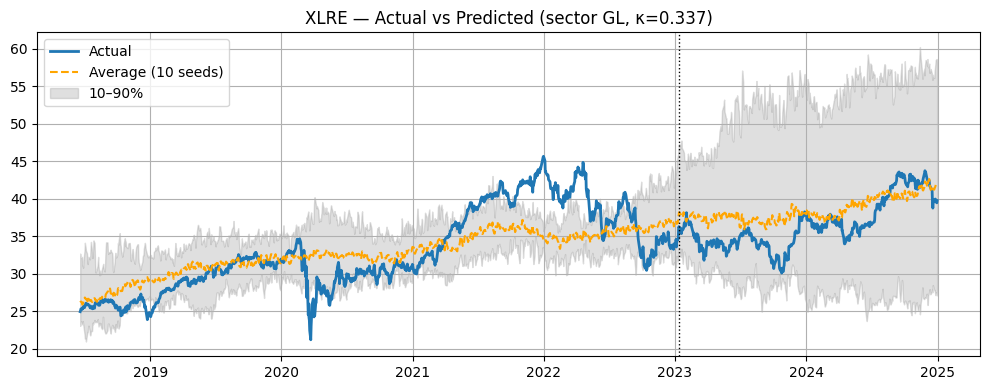

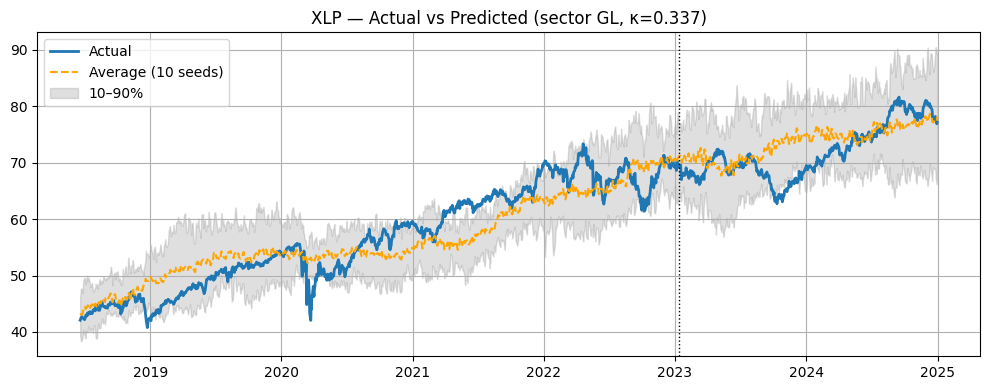

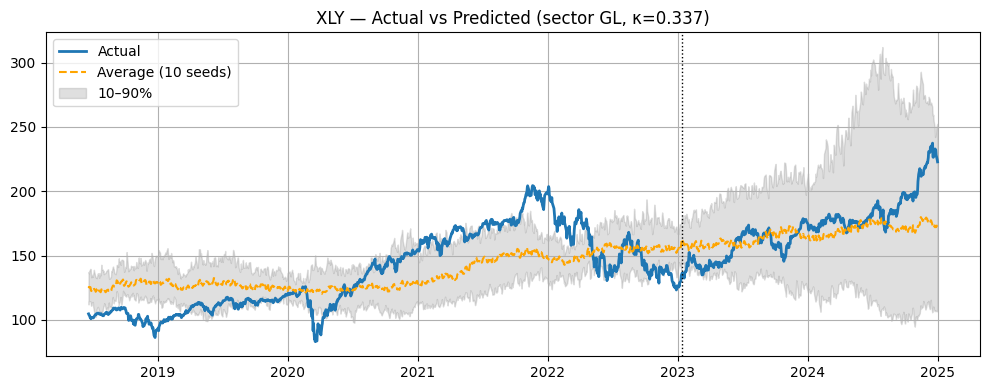

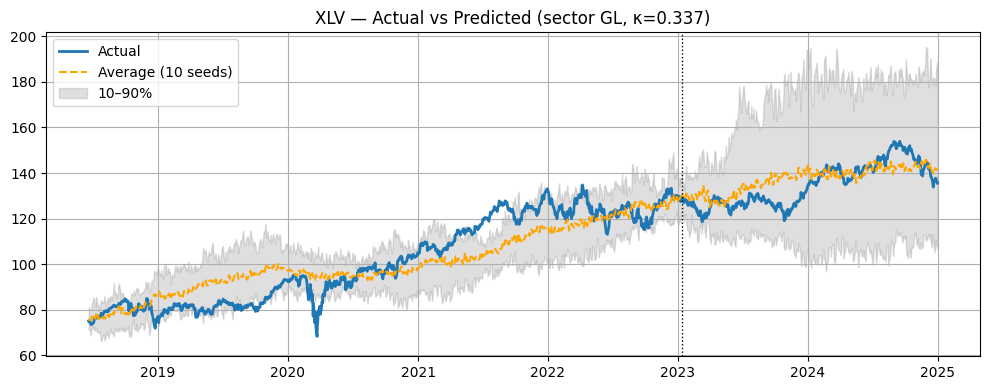

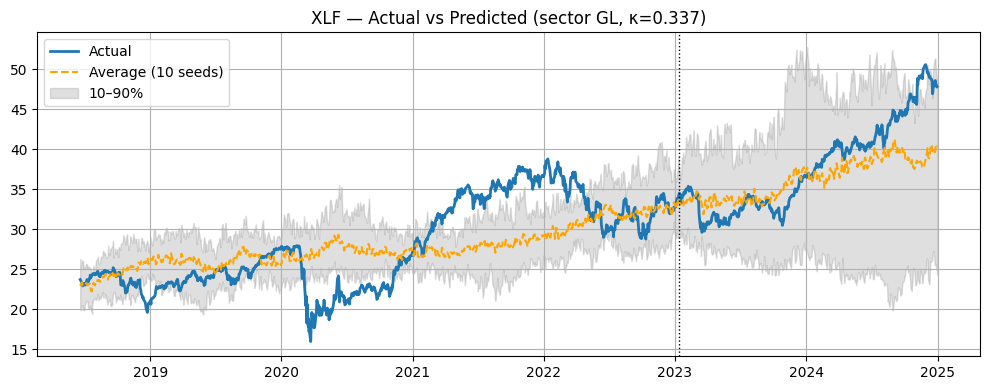

In [21]:
# Sector-level fractional GL — improved, no-leakage, simple & consistent with your SP500 cell
# Adds three low-complexity fixes that usually lift TEST R² across sectors:
#   (1) TRAIN-only parameters per sector (μ, σ, α), with mild shrinkage of α toward 0.5 (reduces noise)
#   (2) Centered GL memory (removes drift bias in the memory term)
#   (3) Tiny TRAIN-only calibration of κ (contagion) over a short grid, then final run averaged over 10 seeds
# Also keeps optional COVID mean/vol shift (calendar-based), but you can disable it.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import nolds

# 0) Settings
N_DAYS       = 1644   # window length (≈2018–2024)
TEST_PCT     = 0.30       # last % as TEST
N_SIM_FINAL  = 10              # ensemble seeds for the final run (averaged path)
SEEDS_FINAL  = [3 + 37*i for i in range(N_SIM_FINAL)]
N_SIM_CAL    = 5               # small ensemble when calibrating κ on TRAIN (fast)
SEEDS_CAL    = [3 + 37*i for i in range(N_SIM_CAL)]

DT           = 1.0             # time step (1 trading day)
DX           = 1.0             # unit spacing on sector lattice
CENTER_MEMORY = True           # center returns before GL memory (removes upward bias)
ALPHA_SHRINK  = 0.6            # shrink α toward 0.5: α = 0.5 + ALPHA_SHRINK*(α_raw-0.5)
COVID_MODE    = "off"          # "off" | "train_meanshift_centered"
COVID_START   = pd.to_datetime("2020-02-20")
COVID_END     = pd.to_datetime("2020-03-30")

# κ grid (TRAIN-only selection). Start at 0 (no contagion)
# Keep it tiny (3–4 points) to stay simple/fast.
KAPPA_BASE = float(kappa_estimate)
KAPPA_GRID = np.array([0.0, 0.5*KAPPA_BASE, 1.0*KAPPA_BASE], dtype="float64")


# 1) Data alignment (use the last N_DAYS on the RETURNS timeline)
T = min(N_DAYS, len(sector_returns))
dates_full     = sector_returns.index[-T:]       # length T (returns timeline)
returns_win_df = sector_returns.loc[dates_full]  # (T, N_x)
prices_win_df  = sector_df.loc[dates_full]  # (T, N_x)

split_idx = int((1.0 - TEST_PCT) * T)
train_idx = np.arange(split_idx)
test_idx  = np.arange(split_idx, T)

sectors = list(ordered_symbols)
N_x = len(sectors)


# 2) TRAIN-only per-sector parameters (μ, σ, α≈H on returns) and GL weights
alpha_dict      = {}
mu_dict_train   = {}
sigma_dict_train= {}
weights_dict    = {}

for sec in sectors:
    r_sec   = returns_win_df[sec].to_numpy().ravel()
    r_train = r_sec[:split_idx]

    # α from Hurst on TRAIN returns, gently shrunk toward 0.5 to stabilize
    alpha_raw = float(nolds.hurst_rs(r_train))
    alpha_j   = 0.5 + ALPHA_SHRINK*(alpha_raw - 0.5)
    alpha_j   = float(np.clip(alpha_j, 0.05, 0.95))
    alpha_dict[sec] = alpha_j

    # TRAIN-only drift and volatility
    mu_j    = float(np.mean(r_train))
    sigma_j = float(np.std(r_train, ddof=1))
    mu_dict_train[sec]     = mu_j
    sigma_dict_train[sec]  = sigma_j

    # GL weights (no truncation), length T
    w = [1.0]
    for k in range(1, T):
        w_k = (1.0 - (alpha_j + 1.0) / k) * w[-1]
        w.append(w_k)
    weights_dict[sec] = np.asarray(w, dtype="float64")

# COVID indices on returns timeline
covid_idx_all = np.where((dates_full >= COVID_START) & (dates_full <= COVID_END))[0]
covid_idx_set = set(covid_idx_all)
covid_idx_train = covid_idx_all[covid_idx_all < split_idx]

# Build μ_t and σ_t paths per sector (TRAIN-only mean-shift during COVID if enabled)
mu_path = np.zeros((T, N_x), dtype="float64")
sg_path = np.zeros((T, N_x), dtype="float64")
for j, sec in enumerate(sectors):
    mu_j, sg_j = mu_dict_train[sec], sigma_dict_train[sec]
    mu_path[:, j] = mu_j
    sg_path[:, j] = sg_j

    if COVID_MODE == "train_meanshift_centered" and covid_idx_all.size > 0:
        if covid_idx_train.size > 0:
            mu_covid = float(returns_win_df[sec].iloc[covid_idx_train].mean())
        else:
            mu_covid = mu_j - 0.5 * sg_j   # conservative negative shift if COVID sits in TEST
        mu_path[covid_idx_all, j] = mu_covid
        sg_path[covid_idx_all, j] = 4.0 * sg_j  # same order as SP500 “final” cell


# 3) Core simulator (given κ and seed) -> PRICE levels (T, N_x), no leakage
#     - GL memory (centered if requested)
#     - Finite-difference diffusion across sectors
#     - TRAIN-only drift correction + TRAIN-only OLS scale per sector
def simulate_one_path(kappa_val: float, seed: int) -> np.ndarray:
    np.random.seed(seed)

    # Simulated log-returns
    R_sim = np.zeros((T, N_x), dtype="float64")
    R_sim[0, :] = returns_win_df.iloc[0].to_numpy()

    for t in range(1, T):
        # diffusion uses neighbors from t-1
        for j, sec in enumerate(sectors):
            alpha_j = alpha_dict[sec]
            w = weights_dict[sec]

            # GL memory term: centered or raw
            if CENTER_MEMORY:
                past = R_sim[:t, j] - mu_path[:t, j]
                D_alpha = float(np.dot(w[:t], past[::-1])) / (DT ** alpha_j)
            else:
                D_alpha = float(np.dot(w[:t], R_sim[t-1::-1, j])) / (DT ** alpha_j)

            # diffusion (Neumann-like boundaries on returns at t-1)
            if j == 0:
                left   = R_sim[t-1, j+1]
                center = R_sim[t-1, j]
                right  = R_sim[t-1, j+1]
            elif j == N_x - 1:
                left   = R_sim[t-1, j-1]
                center = R_sim[t-1, j]
                right  = R_sim[t-1, j-1]
            else:
                left   = R_sim[t-1, j-1]
                center = R_sim[t-1, j]
                right  = R_sim[t-1, j+1]
            diffusion = kappa_val * (right - 2.0*center + left) / (DX**2)

            # stochastic innovation (Gaussian, as in your base)
            z = np.random.normal(0.0, 1.0)

            # recursive update (keeps your Δt^α factor)
            mu_eff, sg_eff = mu_path[t, j], sg_path[t, j]
            R_sim[t, j] = ((mu_eff + sg_eff*z + diffusion) * (DT ** alpha_j)) + D_alpha

    # Back to log-levels (align the starting point per sector)
    logP0 = np.log(prices_win_df.iloc[0].to_numpy().ravel())     # (N_x,)
    log_start = logP0 - R_sim[0, :]                               # so that logP0 = log_start + R_sim[0]

    cum_R = np.cumsum(R_sim, axis=0)                              # (T, N_x)

    # TRAIN-only drift correction: align end-of-TRAIN log-level (no peeking at TEST)
    logP_train_end_real = np.log(prices_win_df.iloc[split_idx].to_numpy().ravel())
    train_len = len(train_idx)
    adj = (logP_train_end_real - (log_start + cum_R[train_idx][-1, :])) / float(train_len)  # (N_x,)

    ramp = np.arange(1, T+1, dtype="float64")[:, None]            # (T,1)
    logP_sim = log_start[None, :] + cum_R + ramp * adj[None, :]   # (T, N_x)

    P_sim = np.exp(logP_sim)

    # TRAIN-only OLS scaling per sector
    P_real_train = prices_win_df.iloc[:split_idx].to_numpy()
    P_sim_train  = P_sim[:split_idx, :]

    num = np.sum(P_sim_train * P_real_train, axis=0)
    den = np.sum(P_sim_train * P_sim_train, axis=0)
    scale = np.divide(num, den, out=np.ones_like(num), where=den > 0)

    P_sim *= scale[None, :]
    return P_sim  # (T, N_x)


# 4) TRAIN-only selection of κ over a tiny grid (fast, simple)
def train_rmse_for_kappa(kappa_val: float) -> float:
    # small ensemble to reduce Monte Carlo noise
    sims = np.stack([simulate_one_path(kappa_val, sd) for sd in SEEDS_CAL], axis=0)  # (N_SIM_CAL, T, N_x)
    P_avg_train = sims.mean(axis=0)[:split_idx, :]  # (split_idx, N_x)

    y_train = prices_win_df.iloc[:split_idx].to_numpy()
    rmse = np.sqrt(np.mean((P_avg_train - y_train)**2))  # global RMSE across sectors (TRAIN only)
    return float(rmse)

kappa_scores = [(kv, train_rmse_for_kappa(kv)) for kv in KAPPA_GRID]
kappa_best, _ = min(kappa_scores, key=lambda x: x[1])


# 5) Final ensemble with best κ, TEST-only metrics, and plots
paths = np.stack([simulate_one_path(kappa_best, sd) for sd in SEEDS_FINAL], axis=0)  # (N_SIM_FINAL, T, N_x)
P_avg = paths.mean(axis=0)    # (T, N_x)

# Percentile bands (optional)
P_p10 = np.percentile(paths, 10, axis=0)
P_p90 = np.percentile(paths, 90, axis=0)

# TEST metrics per sector
RMSE_list = np.zeros(N_x)
MAE_list  = np.zeros(N_x)
R2_list   = np.zeros(N_x)

print("📊 Sector-level TEST performance — averaged seeds, no leakage")
print(f"    κ* selected on TRAIN from grid {list(KAPPA_GRID)} -> {kappa_best:.6f}\n")

for j, sec in enumerate(sectors):
    y_true_test = prices_win_df[sec].to_numpy().ravel()[test_idx]
    y_pred_test = P_avg[:, j][test_idx]

    RMSE_list[j] = float(np.sqrt(mean_squared_error(y_true_test, y_pred_test)))
    MAE_list[j]  = float(mean_absolute_error(y_true_test, y_pred_test))
    R2_list[j]   = float(r2_score(y_true_test, y_pred_test))

    print(f"{sec:>5} | RMSE: {RMSE_list[j]:.4f} | MAE: {MAE_list[j]:.4f} | R²: {R2_list[j]:.4f}")

# Bar chart of TEST R² by sector (ordered)
order = np.argsort(R2_list)
labels_ord = [sectors[i] for i in order]
r2_ord = R2_list[order]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(labels_ord, r2_ord)
ax.axhline(0.0, color="k", linewidth=1, alpha=0.5)
ax.set_title(r"Out-of-sample $R^2$ by sector (TEST)")
ax.set_xlabel("Sectors"); ax.set_ylabel(r"$R^2$")
ax.set_ylim(min(-0.2, r2_ord.min() - 0.05), max(1.0, r2_ord.max() + 0.05))
for b, v in zip(bars, r2_ord):
    ax.annotate(f"{v:.2f}",
                xy=(b.get_x() + b.get_width()/2, v),
                xytext=(0, 4 if v >= 0 else -12),
                textcoords="offset points",
                ha="center", va="bottom" if v >= 0 else "top",
                fontsize=9)
plt.tight_layout(); plt.show()

# Plot Actual vs Average path for the sectors with 10–90% bands
for sec in labels_ord:  
    j = sectors.index(sec)
    plt.figure(figsize=(10, 4))
    plt.plot(dates_full, prices_win_df[sec].to_numpy().ravel(), label='Actual', linewidth=2)
    plt.plot(dates_full, P_avg[:, j], label=f'Average ({N_SIM_FINAL} seeds)', linestyle='--', color='orange')
    plt.fill_between(dates_full, P_p10[:, j], P_p90[:, j], color='gray', alpha=0.25, label='10–90%')
    plt.axvline(dates_full[split_idx], color="k", linestyle=":", linewidth=1)
    plt.title(f"{sec} — Actual vs Predicted (sector GL, κ={kappa_best:.3g})")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [22]:
# ==== Extra: Train/Test/All metrics per sector + band coverage (TEST) ====
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred, eps=1e-12):
    denom = (np.abs(y_true) + np.abs(y_pred)).clip(min=eps)
    return 100.0 * float(np.mean(np.abs(y_pred - y_true) / denom))

y_all   = prices_win_df.to_numpy()   # (T, N_x)
yhat_all = P_avg                     # (T, N_x)

rows = []
for j, sec in enumerate(sectors):
    yt_tr = y_all[:split_idx, j];    yp_tr = yhat_all[:split_idx, j]
    yt_te = y_all[split_idx:, j];    yp_te = yhat_all[split_idx:, j]
    yt_all = y_all[:, j];            yp_all = yhat_all[:, j]

    # Coverage of your 10–90% bands on TEST (if available)
    if 'P_p10' in globals() and 'P_p90' in globals():
        cover_10_90 = float(np.mean((yt_te >= P_p10[split_idx:, j]) & (yt_te <= P_p90[split_idx:, j])))
    else:
        cover_10_90 = np.nan

    rows.append({
        "Sector": sec,
        "R2_train":  float(r2_score(yt_tr, yp_tr)),
        "R2_test":   float(r2_score(yt_te, yp_te)),
        "R2_all":    float(r2_score(yt_all, yp_all)),
        "RMSE_test": float(np.sqrt(mean_squared_error(yt_te, yp_te))),
        "MAE_test":  float(mean_absolute_error(yt_te, yp_te)),
        "sMAPE_test(%)": smape(yt_te, yp_te),
        "Bias_test": float(np.mean(yp_te - yt_te)),
        "Cover10-90_test": cover_10_90
    })

metrics_sectors = pd.DataFrame(rows).set_index("Sector").sort_values("R2_test", ascending=False)
print("\n=== Sector metrics (sorted by R2_test) ===")
print(metrics_sectors.round(4))


=== Sector metrics (sorted by R2_test) ===
        R2_train  R2_test  R2_all  RMSE_test  MAE_test  sMAPE_test(%)  \
Sector                                                                  
XLF       0.3086   0.5052  0.6206     3.9140    2.8918         3.7158   
XLV       0.7763   0.4183  0.8597     7.1279    5.6430         2.0921   
XLY       0.3790   0.2852  0.5228    18.3086   13.7257         3.9578   
XLP       0.8129   0.2416  0.8599     4.1221    3.1884         2.2227   
XLRE      0.5542   0.1736  0.5528     2.9721    2.5065         3.4256   
XLB       0.6002   0.1152  0.7367     5.9671    4.8212         2.9044   
XLI       0.7048  -0.4562  0.7089    16.8071   13.2098         5.9129   
XLU       0.8007  -0.7764  0.5738     8.9980    7.8103         5.8890   
XLC       0.1889  -1.6886 -0.0303    21.4177   16.9453        12.2379   
XLK       0.7111  -1.9210  0.5469    53.6306   46.0823        13.2420   
XLE       0.4415  -2.8220  0.7120    10.7062    9.5858         6.1991   

      

In [24]:
# Sector summary table (parameters + TEST metrics) — English comments and safe fallbacks
# - Uses TRAIN-only parameters when available (alpha_dict, mu_dict_train, sigma_dict_train)
# - Falls back to your earlier dicts (hurst_dict, mu_dict, sigma_dict)
# - Uses TEST metrics arrays (R2_list, RMSE_list, MAE_list or MSE_list)

import pandas as pd
from tabulate import tabulate

# Use your existing sector list if defined; otherwise fall back to the explicit order you provided
sectors = list(ordered_symbols) if 'ordered_symbols' in globals() else ['XLY','XLK','XLC','XLU','XLV','XLRE','XLE','XLF','XLI','XLB']

# Helper to pick the first available variable from globals()
def pick_name(*names):
    g = globals()
    for n in names:
        if n in g:
            return g[n]
    return None

# Prefer TRAIN-only parameter dicts; otherwise use your original dicts
alpha_dict_src = pick_name('alpha_dict', 'hurst_dict')           # α per sector (TRAIN if available)
mu_dict_src    = pick_name('mu_dict_train', 'mu_dict')           # μ per sector
sigma_dict_src = pick_name('sigma_dict_train', 'sigma_dict')     # σ per sector

# Metrics (TEST): prefer MAE_list, fall back to MSE_list (your code used MSE_list to store MAE)
R2_arr   = pick_name('R2_list')
RMSE_arr = pick_name('RMSE_list')
MAE_arr  = pick_name('MAE_list', 'MSE_list')

# Table skeleton: rows = parameters, columns = sectors
rows = ['α', 'μ', 'σ', 'MAE (test)', 'RMSE (test)', 'R² (test)']
table = pd.DataFrame(index=rows, columns=sectors, dtype='float64')

# Fill table
for i, sec in enumerate(sectors):
    # Parameters
    table.at['α', sec] = float(alpha_dict_src.get(sec, float('nan'))) if alpha_dict_src else float('nan')
    table.at['μ', sec] = float(mu_dict_src.get(sec, float('nan')))    if mu_dict_src    else float('nan')
    table.at['σ', sec] = float(sigma_dict_src.get(sec, float('nan'))) if sigma_dict_src else float('nan')
    # TEST metrics
    if MAE_arr  is not None: table.at['MAE (test)',  sec] = float(MAE_arr[i])
    if RMSE_arr is not None: table.at['RMSE (test)', sec] = float(RMSE_arr[i])
    if R2_arr   is not None: table.at['R² (test)',   sec] = float(R2_arr[i])

# Pretty print
print(tabulate(table, headers='keys', tablefmt='grid', floatfmt=".4f"))

+-------------+---------+--------+--------+---------+---------+---------+---------+--------+---------+--------+--------+
|             |     XLE |    XLF |    XLB |     XLI |     XLC |     XLK |     XLY |   XLRE |     XLU |    XLP |    XLV |
+=============+=========+========+========+=========+=========+=========+=========+========+=========+========+========+
| α           |  0.5116 | 0.5285 | 0.5164 |  0.5285 |  0.4868 |  0.4777 |  0.5083 | 0.5288 |  0.5403 | 0.5011 | 0.4960 |
+-------------+---------+--------+--------+---------+---------+---------+---------+--------+---------+--------+--------+
| μ           |  0.0004 | 0.0003 | 0.0004 |  0.0004 |  0.0001 |  0.0006 |  0.0002 | 0.0003 |  0.0004 | 0.0004 | 0.0005 |
+-------------+---------+--------+--------+---------+---------+---------+---------+--------+---------+--------+--------+
| σ           |  0.0239 | 0.0174 | 0.0158 |  0.0155 |  0.0159 |  0.0181 |  0.0165 | 0.0158 |  0.0145 | 0.0112 | 0.0124 |
+-------------+---------+-------

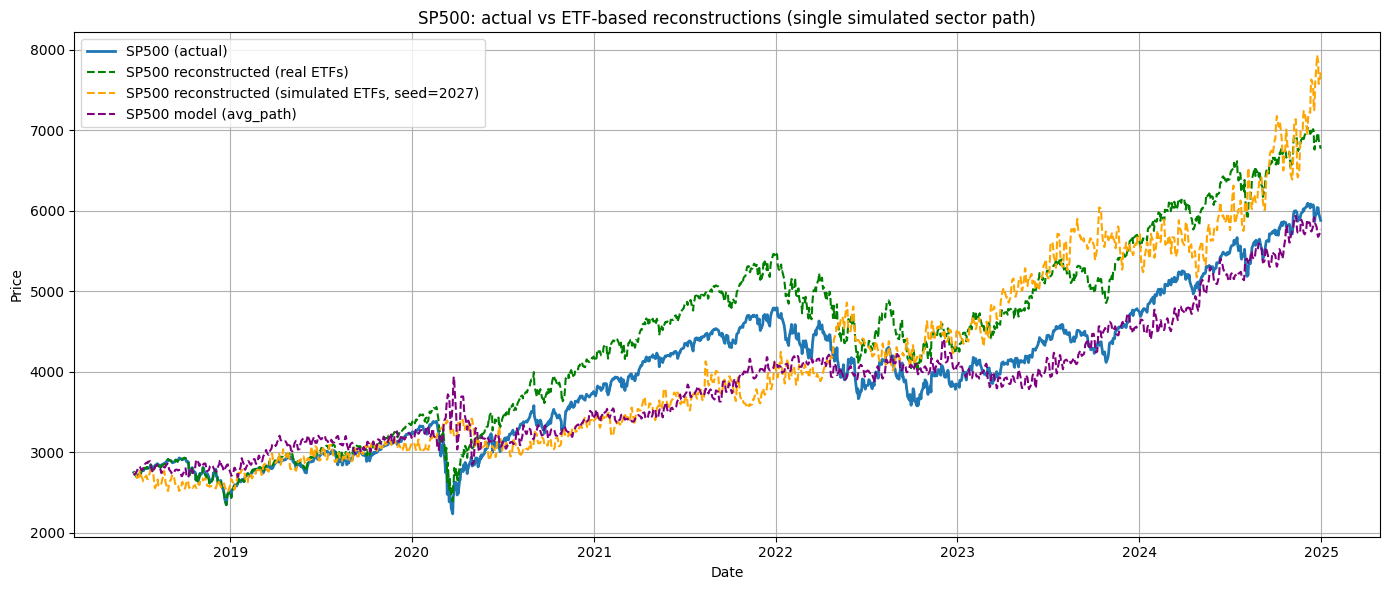


📊 SP500 model vs actual (reference line):
  RMSE: 346.7932
  MAE : 270.6507
  R²  : 0.8507

📊 Reconstruction: real-ETF vs simulated-ETF (single path):
  RMSE: 594.4734
  MAE : 434.5168
  R²  : 0.7481


In [30]:
# Reconstruct SP500 using a SINGLE simulated sector path (one common seed),
# aligned to the SP500 model timeline (avg_path). No averaging across simulations.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 0) Config
SEED_SINGLE = 2027  # choose any integer seed; same path is used for ALL sectors (common seed)
LABEL_MODEL = "SP500 model (avg_path)"  # label for existing avg_path line

# 1) SP500 timeline consistent with avg_path
# avg_path is length len(prices_win) - 1, so the natural date index is prices_win.index[1:]
dates_model = prices_win.index[1:]   # (T_sp,)
sp500_model = pd.Series(np.asarray(avg_path, dtype="float64"), index=dates_model)  # (T_sp,)
sp500_real  = prices_win.loc[dates_model].astype("float64") # (T_sp,)

# 2) Sector panels aligned to dates_model
# Prefer the already-aligned sector window; fall back to sector_df if needed
sectors_real = prices_win_df.copy() if 'prices_win_df' in globals() else sector_df.copy()
sectors_cols = list(sectors_real.columns)

# Simulated single-path sector panel using your sector simulator (MUST be defined earlier)
# simulate_one_path(kappa_val, seed) -> returns PRICE levels (T, N_x) indexed by dates_full
if 'simulate_one_path' not in globals():
    raise NameError("simulate_one_path is not defined. Run your final sector cell first.")
# κ to use: prefer the TRAIN-selected kappa_best; fall back to KAPPA or kappa_estimate
kappa_to_use = None
for name in ('kappa_best', 'KAPPA', 'kappa_estimate'):
    if name in globals():
        kappa_to_use = globals()[name]
        break
if kappa_to_use is None:
    raise NameError("No κ found. Define kappa_best (preferred) or KAPPA/kappa_estimate first.")

# Generate a SINGLE sector path
P_single = simulate_one_path(float(kappa_to_use), SEED_SINGLE)           # (T_sec, N_x)
P_single_df = pd.DataFrame(P_single, index=dates_full, columns=ordered_symbols)

# Reindex both real & simulated panels to the SP500 model timeline and same column order
sectors_real = sectors_real.reindex(dates_model)[sectors_cols].astype("float64")
sectors_sim  = P_single_df.reindex(dates_model)[sectors_cols].astype("float64")

# Drop any dates with missing values to fully align all series
valid_mask = sectors_real.notna().all(axis=1) & sectors_sim.notna().all(axis=1)
dates_use  = sectors_real.index[valid_mask]

sp500_real  = sp500_real.reindex(dates_use)
sp500_model = sp500_model.reindex(dates_use)
sectors_real = sectors_real.loc[dates_use]
sectors_sim  = sectors_sim.loc[dates_use]

# -----------------------------
# 3) Sector weights (11 tickers), mapped to column order and normalized to 1
# -----------------------------
weights_map = {
    "XLY": 0.10,  # Consumer Discretionary
    "XLK": 0.30,  # Information Technology
    "XLC": 0.09,  # Communication Services
    "XLU": 0.03,  # Utilities
    "XLV": 0.13,  # Health Care
    "XLRE": 0.03, # Real Estate
    "XLE": 0.04,  # Energy
    "XLF": 0.12,  # Financials
    "XLI": 0.08,  # Industrials
    "XLB": 0.03,  # Materials
    "XLP": 0.05,  # Consumer Staples
}
missing = [s for s in sectors_cols if s not in weights_map]
if missing:
    raise ValueError(f"Missing weights for sectors present in the panel: {missing}")
weights_vec = np.array([weights_map[s] for s in sectors_cols], dtype="float64")
weights_vec = weights_vec / weights_vec.sum()  # ensure sum = 1
wcol = weights_vec.reshape(-1, 1)

# -----------------------------
# 4) Reconstruct SP500 from ETFs (real & single-path simulated), scaled to the same start level
# -----------------------------
sp500_real_from_etf = (sectors_real.values @ wcol).ravel()
sp500_sim_from_etf  = (sectors_sim.values  @ wcol).ravel()

start_level = float(sp500_real.iloc[0])
scale_real = start_level / float(sp500_real_from_etf[0])
scale_sim  = start_level / float(sp500_sim_from_etf[0])

sp500_real_from_etf_scaled = sp500_real_from_etf * scale_real
sp500_sim_from_etf_scaled  = sp500_sim_from_etf  * scale_sim

# -----------------------------
# 5) Plot (single simulated sector path, not averaged)
# -----------------------------
plt.figure(figsize=(14, 6))
plt.plot(dates_use, sp500_real.values,                 label='SP500 (actual)', linewidth=2)
plt.plot(dates_use, sp500_real_from_etf_scaled,        label='SP500 reconstructed (real ETFs)', linestyle='--', color='green')
plt.plot(dates_use, sp500_sim_from_etf_scaled,         label=f'SP500 reconstructed (simulated ETFs, seed={SEED_SINGLE})', linestyle='--', color='orange')
# Optional: your SP500 model line (avg_path) for reference
plt.plot(dates_use, sp500_model.values,                label=LABEL_MODEL, linestyle='--', color='purple')

plt.title("SP500: actual vs ETF-based reconstructions (single simulated sector path)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 6) Metrics (on the aligned dates)
# -----------------------------
print("\n📊 SP500 model vs actual (reference line):")
print(f"  RMSE: {np.sqrt(mean_squared_error(sp500_real.values, sp500_model.values)):.4f}")
print(f"  MAE : {mean_absolute_error(sp500_real.values, sp500_model.values):.4f}")
print(f"  R²  : {r2_score(sp500_real.values, sp500_model.values):.4f}")

print("\n📊 Reconstruction: real-ETF vs simulated-ETF (single path):")
print(f"  RMSE: {np.sqrt(mean_squared_error(sp500_real_from_etf_scaled, sp500_sim_from_etf_scaled)):.4f}")
print(f"  MAE : {mean_absolute_error(sp500_real_from_etf_scaled, sp500_sim_from_etf_scaled):.4f}")
print(f"  R²  : {r2_score(sp500_real_from_etf_scaled, sp500_sim_from_etf_scaled):.4f}")